# Argument Intent Linter

The previous notebooks have all focused on using Loki to perform code transformations. Loki can also be used as a Fortran linter. In this notebook, we will use Loki to check whether the declared intent of a subroutine argument is consistent with how that variable is used.

Although the notebook is illustrated using very simple code, by the end of it we will have built a program capable of linting IFS code. The finished program can be found in `example/scripts/intent_lint.py`.

Let us start by first examining the sample code that we will use to illustrate this notebook:

In [1]:
from loki import Sourcefile

source = Sourcefile.from_file('src/intent_test.F90')
print(source.to_fortran())


MODULE kernel_mod
  USE parkind1, ONLY: jpim, jprb
  
  IMPLICIT NONE
  
CONTAINS
  SUBROUTINE some_kernel (n, var_out, var_in, var_inout, x, l, h)
    
    !-------------
    !    arguments
    !-------------
    
    INTEGER(KIND=jpim), INTENT(IN) :: n, h, l
    
    REAL(KIND=jprb), INTENT(IN) :: var_in(n)
    REAL(KIND=jprb), INTENT(INOUT) :: var_out(n)
    REAL(KIND=jprb), INTENT(IN) :: var_inout(n)
    
    REAL(KIND=jprb), INTENT(IN) :: x(n)
    
    !-------------------
    !    local variables
    !-------------------
    
    
  END SUBROUTINE some_kernel
END MODULE kernel_mod

SUBROUTINE intent_test (m, n, var_in, var_out, var_inout)
  USE parkind1, ONLY: jpim, jprb
  USE kernel_mod, ONLY: some_kernel
  
  IMPLICIT NONE
  
  !-------------
  !    arguments
  !-------------
  
  INTEGER(KIND=jpim), INTENT(IN) :: m, n
  
  REAL(KIND=jprb), INTENT(IN) :: var_in(n, n, n)
  REAL(KIND=jprb), INTENT(OUT) :: var_out(n, n, n)
  REAL(KIND=jprb), INTENT(INOUT) :: var_inout(n, n, n)
  

## Retrieving variable intent

In the Loki IR, variables are stored as symbol nodes with base `class` [`MetaSymbol`](https://sites.ecmwf.int/docs/loki/master/loki.expression.symbols.html#loki.expression.symbols.MetaSymbol) and the `intent` of a variable is stored in the `property` [`MetaSymbol.type`](https://sites.ecmwf.int/docs/loki/master/loki.expression.symbols.html#loki.expression.symbols.MetaSymbol.type).

We can list all the declared variables by applying the [`FindVariables`](https://sites.ecmwf.int/docs/loki/master/loki.expression.expression.html?highlight=findvariables#loki.expression.expression.FindVariables) visitor is applied to the specification [`Section`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Section) of [`Subroutine`](https://sites.ecmwf.int/docs/loki/master/loki.subroutine.html#loki.subroutine.Subroutine) `'intent_test'`:  

In [2]:
from loki import FindVariables

routine = source['intent_test']
vars = FindVariables().visit(routine.spec)

print('vars:',*vars,'\n')

in_vars = []
out_vars = []
inout_vars = []

for i,var in enumerate(vars):
    intent = getattr(var.type,"intent")

    if intent == "in":
       in_vars.append(var)
    elif intent == "out":
       out_vars.append(var)
    elif intent == "inout":
       inout_vars.append(var)

print('in:',*in_vars,'out:',*out_vars,'inout:',*inout_vars)

vars: h k jpim y(:) x(:) m some_kernel i j jprb n l var_in(n, n, n) var_inout(n, n, n) var_out(n, n, n) 

in: m n var_in(n, n, n) out: var_out(n, n, n) inout: var_inout(n, n, n)


`intent_test` also contains an [`Associate`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Associate) statement that features an `intent(out)` variable on the `rhs`. `vout` should therefore also be added to the list of `intent(out)` variables:

In [3]:
from loki import FindNodes,Associate

assoc = FindNodes(Associate).visit(routine.body)[0]
for vars,expr in assoc.associations:
    varlist = FindVariables().visit(vars)
    print('expr:',expr,'vars:',*varlist)

expr: vout vars: n m m var_out(n, m, m)


In this case, the `FindVariables` visitor also returns the integers `n`,`m`. This could lead to some confusion as to exactly which variables are being associated with the expression `vout`. We will encounter the same issue when an [`Array`](https://sites.ecmwf.int/docs/loki/master/loki.expression.symbols.html#loki.expression.symbols.Array) appears in an [`Assignment`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Assignment) expression. This is easily remedied by wrapping a small function around `FindVariables`:

In [4]:
from loki import Array

def FindVarsNotDims(o,Return="var"):

#   retrieve all variables from expression/node
    varlist = FindVariables().visit(o)

#   build list of variables that are used as array dimensions
    dims = []
    for var in varlist:
        if isinstance(var,Array):
            dims += FindVariables().visit(var.dimensions)

#   remove duplicates from dims
    dims = list(dict.fromkeys(dims))

#   build list of var names that does not include dimensions
    if Return == "var":
        buf = [var for var in varlist if not var in dims]
    else:
        buf = [var.name for var in varlist if not var in dims]
                
    return buf

for vars,expr in assoc.associations:
    varlist = FindVarsNotDims(vars)
    print('expr:',expr,'vars:',*varlist,'\n')
    
    for var in varlist:
        intent = getattr(var.type,"intent")
    
        if intent == "in":
            in_vars.append(expr)
        elif intent == "out":
            out_vars.append(expr)
        elif intent == "inout":
            inout_vars.append(expr)

print('out:',*out_vars)

expr: vout vars: var_out(n, m, m) 

out: var_out(n, n, n) vout


## Modifying variable values

Putting aside function or subroutine calls for the moment (and also ignoring I/O), there are only two mechanisms for modifying the value of a variable. The obvious one is an [`Assignment`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Assignment) statement, where the `rhs` value is assigned to the `lhs` value.

Values can also be assigned to a variable by using it as the induction variable of a loop. Although an extremely unusual practice, Fortran compilers do allow dummy arguments of kind `intent(out)` or `intent(inout)`  to be used as the induction variables of a loop. This is however (in my humble opinion) bad coding practice; for ease of readability, local variables rather than arguments should be used as loop induction variables. Therefore in our linter rules, we will forbid the use of variables with declared `intent` as loop induction variables.

The next section creates linter rules for checking `intent` consistency within the `Subroutine` body. We will later examine how this can be extended to function calls.

## Checking `intent` in `Subroutine` body

Let us first check that variables with declared `intent` are not used as loop induction variables:

In [5]:
from loki import Loop

# check that variables with declared intent aren't used as loop induction variable
loops = FindNodes(Loop).visit(routine.body)

# intialize intent(in) rule checks: all rules must be 'True'
in_check = {var:True for var in in_vars}

# intialize intent(out) rule checks: all rules must be 'True'
out_check = {var:True for var in out_vars}

# intialize intent(inout) rule checks: all rules must be 'True'
inout_check = {var:True for var in inout_vars}

for loop in loops:
    if(loop.variable in in_vars):
        in_check[loop.variable] = False
    if(loop.variable in out_vars):
        out_check[loop.variable] = False
    if(loop.variable in inout_vars):
        inout_check[loop.variable] = False
        
def rule_check():

    #  checking if any rules are broken
    for var in in_vars:
        if not in_check[var]:
            print(f'intent(in) rule broken for {var.name}')
    
    for var in out_vars:
        if not out_check[var]:
            print(f'intent(out) rule broken for {var.name}')
    
    for var in inout_vars:
        if not inout_check[var]:
            print(f'intent(inout) rule broken for {var.name}')

rule_check()

Having confirmed variables with declared `intent` are not used as loop induction variables, we can now check the [`Assignment`](https://sites.ecmwf.int/docs/loki/master/loki.ir.html#loki.ir.Assignment) statements.

For `intent(in)` variables, we don't want their value to be reassigned in the `Subroutine`. Therefore the rule for checking `intent(in)` variables is the simplest: variables of kind `intent(in)` should not appear in the `lhs` of an `Assignment`:

In [6]:
from loki import Assignment

# retrieve all the assignment nodes from the IR
assigns = FindNodes(Assignment).visit(routine.body)

# check that intent(in) vars don't appear on LHS of assignment
for var in in_vars:
    for assign in assigns:

        lhs = FindVarsNotDims(assign.lhs,Return="name")

        if var.name in lhs:
            in_check[var] = False
            break

In the case of `intent(out)` variables, we are not interested in their value coming in to the `Subroutine`, and we wish to reassign their value during the `Subroutine`. Thus in the first `Assignment` statement in which they appear, `intent(out)` variables should be exclusively on the `lhs`:

In [7]:
# check that first appearance of intent(out) is not on RHS
for var in out_vars:
    for assign in assigns:

        rhs = FindVarsNotDims(assign.rhs,Return="name")
        if var.name in rhs:
            out_check[var] = False
            break

        lhs = FindVarsNotDims(assign.lhs,Return="name")
        if var.name in lhs:
            break

In principle, we could build similar checks for `intent(inout)` variables. However, the way in which some Fortran compilers treat `allocatable` variables prevents us from doing so.

If an `allocatable` array is passed to a subroutine as a dummy argument of kind `intent(out)`, some Fortran compilers will deallocate that array upon exiting the subroutine. This is why in the IFS, data arrays are often declared as `intent(inout)`, even though their true intent is `intent(out)`. An example can be seen in the 'cloudsc-dwarf' in `src/cloudsc_driver_mod.F90`: the `REAL` array `PCOVPTOT` is declared `intent(inout)` even though it's value entering the subroutine is never used.

An allocatable array passed as a dummy argument to a subroutine could thus belong to two possible categories:
1. A variable that is truly of type `intent(inout)`
2. A variable that is strictly of type `intent(out)`, but has been declared `intent(inout)` to avoid deallocation

It would be very difficult to discern between the two options from a static analysis of the source code. As such, we will not impose any rules related to `Assignment` expressions for `intent(inout)` variables.

We can however impose the rule that an `allocatable` array that is passed as a dummy argument to a subroutine must be of kind `intent(inout)` or `intent(in)`:

In [8]:
from loki import CallStatement,Allocation

# retrieve CallStatement node
call = FindNodes(CallStatement).visit(routine.body)[0]

# retrieve allocation statements
allocs = FindNodes(Allocation).visit(routine.body)

# build list of allocatable arrays
alloc_vars = []
for alloc in allocs:
    alloc_vars += FindVarsNotDims(alloc.variables,Return="name")

# associate Subroutine object with matching call
routine.enrich_calls(source['some_kernel'])
func = call.context.routine

for i,arg in enumerate(func.arguments):
    for var in FindVarsNotDims(arg,Return="name"):
        if var in alloc_vars:
            
            if getattr(arg.type,"intent") not in ['in','inout']:
                print(f'Allocatable {var} has wrong intent in {func} declaration')

## Building `intent` map between function caller and callee

Clearly, variables can also be reassigned in a function/subroutine call. Whilst our intent linter can easily be applied recursively to examine the body of every called function, we must also ensure that the declared `intent` of an argument passed to the function is consistent with the declared `intent` of that variable in the calling function.

For example, `var_in` is a variable of kind `intent(in)` in `Subroutine` `intent_test`. Therefore `var_in` must not be modified within `intent_test` or any subroutines called by `intent_test`. Therefore in `some_kernel`, `var_in` must also therefore be of kind `intent(in)`. We can thus initialize the mapping for the intent across function calls as follows:

In [9]:
intent_map = {"in":"in"}

The mapping for `intent(out)` variables is a little more complicated and depends on whether the function call is preceded by an `Assignment` statement featuring the variable in question, and if so, whether it appears in the `lhs` or the `rhs` of the assignment. The procedure for building the mapping is best illustrated using the flowchart below:

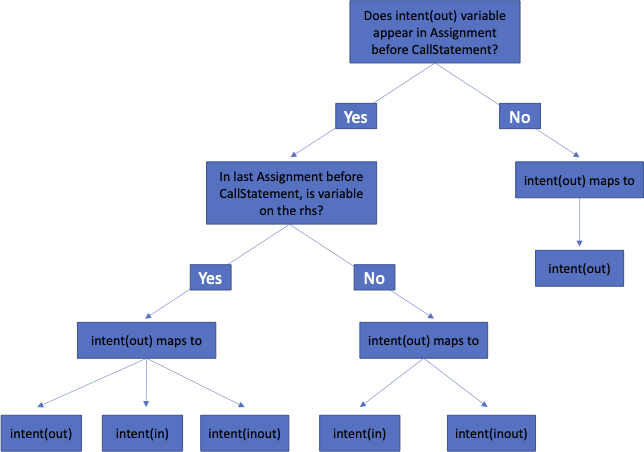

In [10]:
from IPython.display import Image

fig = Image(filename=('gfx/intent_out_map-crop.png'))
fig

A similar process can be used to determine the mapping for `intent(inout)` variables:

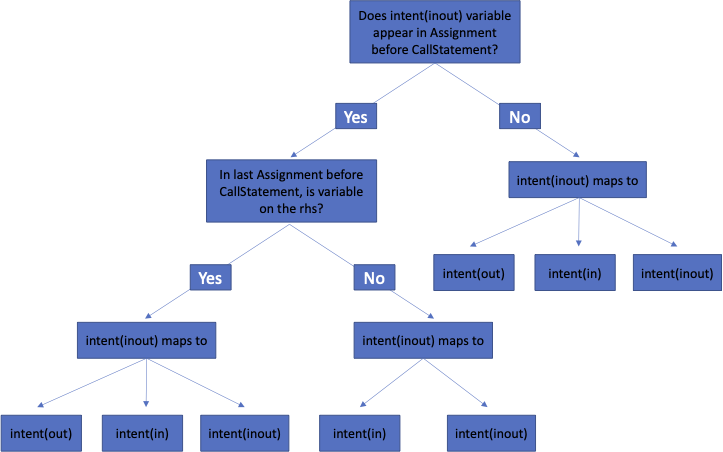

In [11]:
fig = Image(filename=('gfx/intent_inout_map-crop.png'))
fig

You may be wondering why `intent(out)` has been included as a permitted value for the rightmost tree of the above flowchart. It is to account for the following possibility: an allocatable variables is allocted in subroutine A, and passed as a dummy argument to subroutine B. subroutine B must therefore declare the variable as `intent(inout)`. subroutine C then passes the variable as a dummy argument to subroutine C. In subroutine C, the variable can correctly be of any declared intent.

## Checking `intent` consistency across function calls

The code below gives an example of how checking the `intent` consistency across function calls can be implemented:

In [12]:
from loki import CallStatement

calls = FindNodes(CallStatement).visit(routine.body)
nodes = FindNodes((CallStatement,Assignment)).visit(routine.body)

# read-in all subroutines from loaded sourcefile
routines = source.all_subroutines

# associate Subroutine object with matching call
routine.enrich_calls(routines)

# build map of permitted values for intent(in)
intent_map = {"in":"in"}

# loop over all function calls
for call in calls:

#   retrieving subroutine object of function call
    if hasattr(call.context,'routine'):
        func = call.context.routine
    else:
        raise Exception(f'matching routine for {call} not found')

#   determine intent of all positional arguments
    intent = [None]*len(call.arguments+call.kwarguments) 
    for i,arg in enumerate(call.arguments):

        vars = FindVarsNotDims(arg,Return="name")

        for var in (in_vars+out_vars+inout_vars):
            if var.name in vars:
                intent[i] = getattr(var.type,"intent")

#   determine intent of all keyword arguments
    arglen = len(call.arguments)
    for i,(arg,value) in enumerate(call.kwarguments):

        vars = FindVarsNotDims(arg,Return="name")

        for var in (in_vars+out_vars+inout_vars):
            if var.name in vars:
                intent[i+arglen] = getattr(var.type,"intent")

#   determine location of function call relative to assignment nodes
    call_loc = [count for count,node in enumerate(nodes) if node == call][0]
   
#   loop over all positional arguments and check intent consistency
    for i,arg in enumerate(call.arguments):

    #   determine if arg appears in assignment before function call 
        assign_type = None
        for count,node in enumerate(nodes):
            if count == call_loc: break

            if isinstance(node,Assignment):

                lhs = FindVarsNotDims(node.lhs,Return="name")
                rhs = FindVarsNotDims(node.rhs,Return="name")

                if hasattr(arg,"name"):
                    if arg.name in lhs: assign_type = "lhs"
                    if arg.name in rhs: assign_type = "rhs"

        if intent[i] == "out":

        #   build map of permitted values for intent(out)
            if not assign_type:
                intent_map["out"] = "out"
            elif assign_type == "lhs":
                intent_map["out"] = ["in","inout"]    
            else:
                intent_map["out"] = ["in","inout","out"]    

        elif intent[i] == "inout":

        #   build map of permitted values for intent(inout)
            if not assign_type:
                intent_map["inout"] = ["in","inout","out"]
            elif assign_type == "lhs":
                intent_map["inout"] = ["in","inout"]    
            else:
                intent_map["inout"] = ["in","inout","out"]

        if intent[i] is not None:
            if getattr(func.arguments[i].type,"intent") not in intent_map[intent[i]]:   
                print(f'Inconsistent intent in {call} for positional arg {arg.name}')
                
#   loop over all keyword arguments and check intent consistency
    for i,(arg,value) in enumerate(call.kwarguments):

    #   determine if arg appears in assignment before function call 
        assign_type = None
        for count,node in enumerate(nodes):
            if count == call_loc: break

            if isinstance(node,Assignment):
                lhs = FindVariables().visit(node.lhs)
                assign_type = ["lhs" for buf in lhs if var.name == buf.name]

                rhs = FindVariables().visit(node.rhs)
                assign_type = ["rhs" for buf in rhs if var.name == buf.name]

                if assign_type: assign_type = assign_type[0]

        if intent[i+arglen] == "out":

        #   build map of permitted values for intent(out)
            if not assign_type:
                intent_map["out"] = "out"
            elif assign_type == "lhs":
                intent_map["out"] = ["in","inout"]    
            else:
                intent_map["out"] = ["in","inout","out"]    

        elif intent[i+arglen] == "inout":

        #   build map of permitted values for intent(inout)
            if not assign_type:
                intent_map["inout"] = ["in","inout","out"]
            elif assign_type == "lhs":
                intent_map["inout"] = ["in","inout"]    
            else:
                intent_map["inout"] = ["in","inout","out"]


        #   determine position of keyword argument in subroutine declaration
        pos = [pos for pos,dum in enumerate(func.arguments) if arg == dum]
        if pos:
            pos = pos[0]
        else:
            raise Exception(f'keyword argument {arg} not found in {func} declaration')

        if intent[i+arglen] is not None:
            if getattr(func.arguments[pos].type,"intent") not in intent_map[intent[i]]:   
                print(f'Inconsistent intent in {call} for keyword arg {arg.name}')

## Extending to multiple sourcefiles

Our intent linter can easily be extended to multiple source files:

In [13]:
import os,fnmatch

files = fnmatch.filter(os.listdir('src/'),'cloudsc*.F90')

routines = []
for file in files:

    print(f'read in File :: {file}')

    fnm = 'src/'+file

    source  = Sourcefile.from_file(fnm)
    routines += source.all_subroutines

read in File :: cloudsc.F90
read in File :: cloudsc_driver_mod.F90


In order to check all the subroutines defined within the files we read-in, we simply place the program written above inside a loop over `routines`. We can also disable checking the intent consistency across calls to auxiliary IFS functions:

In [14]:
disable = ['TIMER','GET_ENVIRONMENT_VARIABLE','EC_PMON']

routines = []
for file in files:

    print(f'read in File :: {file}')

    fnm = 'src/'+file

    source  = Sourcefile.from_file(fnm)
    routines += source.all_subroutines
    
print()
for routine in routines:
    print(f'checking {routine}')
        
    calls = FindNodes(CallStatement).visit(routine.body)

    remove = []
    for name in disable:
        remove += [call for call in calls if name in call.name]

    calls = [call for call in calls if call not in remove]

    print(*calls)

read in File :: cloudsc.F90
read in File :: cloudsc_driver_mod.F90

checking Subroutine:: CLOUDSC

checking Subroutine:: CLOUDSC_DRIVER
Call:: CLOUDSC


The finished program can be found in `scripts/intent_lint.py`. It has been tested on the 'cloudsc-dwarf'.